In [1]:
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

from sklearn.utils import check_random_state

# implementing OPE of the IPWLearner using synthetic bandit data
from sklearn.linear_model import LogisticRegression, LinearRegression

import matplotlib.pyplot as plt

from scipy.special import softmax
from abc import ABCMeta

# import open bandit pipeline (obp)
# from obp.dataset import OpenBanditDataset
# from obp.dataset import linear_reward_function, logistic_reward_function


from obp.ope import (
    # OffPolicyEvaluation,
    RegressionModel,
    # InverseProbabilityWeighting as IPW,
    DirectMethod as DM,
    # DoublyRobust as DR,
    # SelfNormalizedDoublyRobust as SNDR
)

from my_utils import (
    eval_policy,
    CFModel,
    CustomCFDataset,
    NeighborhoodModel
    # create_simluation_data_from_pi,
    # sample_policy_actions
)
random_state=12345
random_ = check_random_state(random_state)

In [2]:
def calc_reward(dataset, policy):
    return np.array([np.sum(dataset['q_x_a'] * policy.squeeze(), axis=1).mean()])

In [3]:
pd.options.display.float_format = '{:,.4f}'.format

In [4]:
def generate_dataset(params):
    emb_a = random_.normal(size=(params["n_actions"], params["emb_dim"]))
    noise_a = random_.normal(size=(params["emb_dim"]))
    our_a = (1-params["eps"]) * emb_a + params["eps"] * noise_a

    original_a = our_a.copy()

    emb_x = random_.normal(size=(params["n_users"], params["emb_dim"]))
    noise_x = random_.normal(size=(params["emb_dim"])) 
    our_x = (1-params["eps"]) * emb_x + params["eps"] * noise_x
    original_x = our_x.copy()

    score = emb_x @ emb_a.T
    # score = random_.normal(score, scale=params["sigma"])
    q_x_a = (1 / (5.0 + np.exp(-score)))

    return dict(
                emb_a=emb_a,
                our_a=our_a,
                original_a=original_a,
                emb_x=emb_x,
                our_x=our_x,
                original_x=original_x,
                q_x_a=q_x_a,
                n_actions=params["n_actions"],
                n_users=params["n_users"],
                emb_dim=params["emb_dim"]
                )

In [5]:
def create_simluation_data_from_pi(pi: np.ndarray, q_x_a: np.ndarray, n_users: np.int, n_actions: np.int, random_state: int = 12345):
    random_ = check_random_state(random_state)
    simulation_data = {'actions':np.zeros((n_actions, n_users), dtype=np.int32), 
                       'users': np.zeros((n_actions, n_users), dtype=np.int32), 
                       'reward':np.zeros((n_actions, n_users)),
                       'pscore':np.zeros((n_actions, n_users))}
    
    reward = q_x_a  > random_.random(size=q_x_a.shape)
    simulation_data['pi_0'] = pi
    actions = []
    for i in range(n_users):
        user_actions = random_.choice(np.arange(n_actions), size=n_actions, p=pi[i], replace=True)
        actions.append(np.array(user_actions))

    actions = np.vstack(actions)
    for i in range(n_actions):
        simulation_data['actions'][i] = actions[:, i]
        simulation_data['users'][i] = np.arange(n_users)
        qq = q_x_a[np.arange(n_users), simulation_data['actions'][i]]
        simulation_data['reward'][i] = np.squeeze(qq > random_.random(size=qq.shape))
        simulation_data['pscore'][i] = np.squeeze(pi[np.arange(n_users), simulation_data['actions'][i]])
    
    simulation_data['q_x_a'] = reward
    return simulation_data

In [6]:
def get_test_data(dataset, simulation_data, n_test_data):
    return dict(
        num_data=n_test_data*dataset["n_users"],
        num_actions=dataset["n_actions"],
        x=dataset["our_x"][simulation_data['users'][:n_test_data].flatten()],
        a=simulation_data['actions'][:n_test_data].flatten(),
        r=simulation_data['reward'][:n_test_data].flatten(),
        x_idx=simulation_data['users'][:n_test_data].flatten(),
        pi_0=simulation_data['pi_0'],
        pscore=simulation_data['pscore'][:n_test_data].flatten(),
        q_x_a=simulation_data['q_x_a'],
    )

In [7]:
def get_train_data(n_actions, train_size, sim_data, idx, emb_x):
   return dict(
                num_data=train_size,
                num_actions=n_actions,
                x=emb_x[sim_data['users'][idx].flatten()],
                a=sim_data['actions'][idx].flatten(),
                r=sim_data['reward'][idx].flatten(),
                x_idx=sim_data['users'][idx].flatten(),
                pi_0=sim_data['pi_0'],
                pscore=sim_data['pscore'][idx].flatten(),
                q_x_a=sim_data['q_x_a']
                )

In [8]:
class IPWPolicyLoss(nn.Module):
    def __init__(self, log_eps=1e-10):
        super(IPWPolicyLoss, self).__init__()
        self.log_eps = log_eps

    def forward(self, pscore, scores, policy_prob, original_policy_rewards, original_policy_actions):
        n = original_policy_actions.shape[0]

        pi_e_at_position = policy_prob[torch.arange(n), original_policy_actions].squeeze()
        iw = pi_e_at_position / pscore
        iw = iw.detach()
        # q_hat_at_position = scores[torch.arange(n), original_policy_actions].squeeze()
        # dm_grads = (scores * policy_prob.detach() * torch.log(policy_prob)).sum(dim=1)
        log_pi = torch.log(pi_e_at_position).squeeze()
        
        # reinforce trick step
        # reinforce_grad = ((iw * (original_policy_rewards - q_hat_at_position) * log_pi) / iw.sum()) + dm_grads
        reinforce_grad = iw * original_policy_rewards * log_pi
        
        return -reinforce_grad.mean()

In [105]:
class SNDRPolicyLoss(nn.Module):
    def __init__(self, log_eps=1e-10):
        super(SNDRPolicyLoss, self).__init__()
        self.log_eps = log_eps

    def forward(self, pscore, scores, policy_prob, original_policy_rewards, original_policy_actions):
        n = original_policy_actions.shape[0]

        pi_e_at_position = policy_prob[torch.arange(n), original_policy_actions].squeeze()
        iw = pi_e_at_position / pscore
        iw = iw.detach()
        q_hat_at_position = scores[torch.arange(n), original_policy_actions].squeeze()
        dm_reward = (scores * policy_prob.detach()).sum(dim=1)
        log_pi = torch.log(pi_e_at_position).squeeze()
        
        # reinforce trick step
        r_hat = ((iw * (original_policy_rewards - q_hat_at_position)) / iw.sum()) + dm_reward
        reinforce_grad = r_hat * log_pi
        return -reinforce_grad.mean()

In [10]:
def get_ope_results_dict(reg_results, conv_results):
    reward = conv_results[:, 0]
    return dict(
                policy_rewards=reward.mean(),
                ipw=np.mean(abs(conv_results[: ,3] - reward)),
                reg_dm=np.mean(abs(reg_results - reward)),
                conv_dm=np.mean(abs(conv_results[: ,1] - reward)),
                conv_dr=np.mean(abs(conv_results[: ,2] - reward)),
                conv_sndr=np.mean(abs(conv_results[: ,4] - reward)),
                
                ipw_p_err=np.mean(abs(conv_results[: ,3] - reward) / reward) * 100,
                reg_dm_p_err=np.mean(abs(reg_results - reward) / reward) * 100,
                conv_dm_p_err=np.mean(abs(conv_results[: ,1] - reward) / reward) * 100,
                conv_dr_p_err=np.mean(abs(conv_results[: ,2] - reward) / reward) * 100,
                conv_sndr_p_err=np.mean(abs(conv_results[: ,4] - reward) / reward) * 100,
                
                ipw_var=np.std(conv_results[: ,3]),
                reg_dm_var=np.std(reg_results),
                conv_dm_var=np.std(conv_results[: ,1]),
                conv_dr_var=np.std(conv_results[: ,2]),
                conv_sndr_var=np.std(conv_results[: ,4]),
                )

In [12]:
def plot_results(df):
    fig, ax = plt.subplots(figsize=(10, 5))
    for val in ["ipw", "reg_dm", "conv_dm", "conv_dr", "conv_sndr"]:
        ci = df[val + '_var']
        ax.plot(df.index, df[val], label=val)
        ax.fill_between(df.index, (df[val]-ci), (df[val]+ci), alpha=.1, linestyle='--')


    plt.xlabel("Number of training data")
    plt.ylabel("Policy value error")
    plt.title("IPW vs DM vs DR vs SNDR Errors")
    plt.legend()
    plt.show()
    plt.clf()
    
    df.plot(
    y=["ipw_p_err", "reg_dm_p_err", "conv_dm_p_err", "conv_dr_p_err", "conv_sndr_p_err"],
    title="IPW vs DM vs DR vs SNDR Errors in percentage",
    xlabel="Number of training data",
    figsize=(10, 5),
    marker="o",
    )
    plt.show()
    plt.clf()

In [13]:
result_path = Path(f"./result/{datetime.now().strftime('%Y-%m-%d')}/train_data")
result_path.mkdir(parents=True, exist_ok=True)
result_file_name = f"result_{datetime.now().strftime('%H:00')}.csv"
curve_file_name = f"curve_{datetime.now().strftime('%H:00')}.csv"
print(result_file_name)

result_21:00.csv


## OPE

We will run several simulations on a generated dataset, the dataset is generated like this:
$$ \text{We have users U and actions A } u_i \sim N(0, I_{emb_dim}) \ a_i \sim N(0, I_{emb_dim})$$
$$ p_{ij} = 1 / (5 + e^{-(u_i.T a_j)}) $$
$$r_{ij} \sim Bin(p_{ij})$$

We have a policy $\pi$
and it's ground truth reward is calculated by
$$R_{gt} = \sum_{i}{\sum_{j}{\pi_{ij} * p_{ij}}} $$

In [14]:
def no_learning_trial(
                      num_runs, 
                      num_neighbors, 
                      num_rounds_list, 
                      dataset
                      ):
    results = {}
    dm = DM()
    our_x, our_a, n_actions = dataset["our_x"], dataset["our_a"], dataset["n_actions"]

    for train_size in num_rounds_list:
        reg_results, conv_results = [], []
        for run in range(num_runs):
            
            greedy = np.ones_like(dataset["q_x_a"])/(dataset["n_actions"])
            pi_0 = softmax(our_x @ our_a.T, axis=1)

            pi_0 = 0.8 * pi_0 + 0.2 * greedy
            simulation_data = create_simluation_data_from_pi(
                                                            pi_0,
                                                            dataset["q_x_a"],
                                                            dataset["n_users"],
                                                            dataset["n_actions"],
                                                            random_state=train_size*(run+1)
                                                            )
            
            # test_data = get_test_data(dataset, simulation_data, n_test_data)
            
            # idx = np.arange(train_size) + n_test_data
            idx = np.arange(train_size)
            train_data = get_train_data(n_actions, train_size, simulation_data, idx, our_x)
            
            regression_model = RegressionModel(
                                                n_actions=n_actions,
                                                action_context=our_x,
                                                base_model=LogisticRegression(random_state=12345)
                                                )
            
            neighberhoodmodel = NeighborhoodModel(
                                                    train_data['x_idx'],
                                                    train_data['a'], 
                                                    our_a,
                                                    our_x, 
                                                    train_data['r'], 
                                                    num_neighbors=num_neighbors
                                                )
            
            original_policy_prob = np.expand_dims(pi_0, -1)
            regression_model.fit(train_data['x'], train_data['a'], train_data['r'], original_policy_prob[train_data['x_idx'], train_data['a']].squeeze())
            policy = np.expand_dims(softmax(our_x @ our_a.T, axis=1), -1)

            # reg_dm = dm.estimate_policy_value(policy[test_data['x_idx']], regression_model.predict(test_data['x']))
            reg_dm = dm.estimate_policy_value(policy[train_data['x_idx']], regression_model.predict(train_data['x']))

            reg_results.append(reg_dm)

            # conv_results.append(eval_policy(neighberhoodmodel, test_data, original_policy_prob[test_data['x_idx']], policy))
            conv_results.append(eval_policy(neighberhoodmodel, train_data, original_policy_prob[train_data['x_idx']], policy))
            conv_results[-1] = np.append(calc_reward(dataset, policy), conv_results[-1])

        reg_results = np.array(reg_results)
        conv_results = np.array(conv_results)

        results[train_size] = get_ope_results_dict(reg_results, conv_results)
        
    return pd.DataFrame.from_dict(results, orient='index')

In [15]:
n_test_data = 5

dataset_params = dict(
                    n_actions= 150,
                    n_users = 150,
                    emb_dim = 5,
                    # sigma = 0.1,
                    eps = 0.2
                    )

dataset = generate_dataset(dataset_params)

# num_rounds_list = [3]
num_rounds_list = [1, 2, 3, 4, 5, 10, 20]

# num_runs = 5 # number of simulations
max_iter = 25 # number of epochs

In [16]:
# dm = DM()
# results = {}
num_runs = 10
batch_size = 50
num_neighbors = 6
# num_rounds_list = [3, 5]

We start with the parameters:
$$EmbDim = 5$$
$$NumActions= 150$$
$$NumUsers = 150$$
$$NeighborhoodSize = 6$$
and we run 10 trials for stability and variance calculation


To test the policy $\pi$
We will use an initial policy : $$\pi_{start} = (1-\epsilon)*\pi + \epsilon * greedy$$ to sample examples from the data
and then use ope tools and the convolution model to calculate $\hat{R}$

#### Initial Noised Policy
This is the first policy we will test out, the policy is:

$$emb = 0.8 * gt + 0.2 * noise$$

In [17]:
df1 = no_learning_trial(num_runs, num_neighbors, num_rounds_list, dataset)

In [18]:
df1

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,ipw_p_err,reg_dm_p_err,conv_dm_p_err,conv_dr_p_err,conv_sndr_p_err,ipw_var,reg_dm_var,conv_dm_var,conv_dr_var,conv_sndr_var
1,0.1872,0.0353,0.0266,0.0242,0.0266,0.0345,18.8350,14.1998,12.9072,14.2127,18.4044,0.0354,0.0322,0.0330,0.0336,0.0385
2,0.1872,0.0217,0.0118,0.0114,0.0147,0.0221,11.5673,6.2909,6.1030,7.8590,11.8074,0.0265,0.0148,0.0141,0.0143,0.0215
3,0.1872,0.0244,0.0192,0.0116,0.0151,0.0223,13.0434,10.2567,6.1852,8.0508,11.9360,0.0262,0.0164,0.0130,0.0152,0.0228
4,0.1872,0.0146,0.0193,0.0140,0.0142,0.0145,7.8232,10.3159,7.4896,7.5751,7.7466,0.0189,0.0187,0.0164,0.0174,0.0196
5,0.1872,0.0219,0.0133,0.0154,0.0164,0.0207,11.6860,7.0805,8.2088,8.7413,11.0358,0.0212,0.0145,0.0156,0.0168,0.0209
10,0.1872,0.0140,0.0076,0.0085,0.0094,0.0118,7.4781,4.0417,4.5175,5.0278,6.3183,0.0168,0.0069,0.0105,0.0112,0.0136
20,0.1872,0.0100,0.0104,0.0075,0.0065,0.0056,5.3347,5.5365,4.0168,3.4681,2.9985,0.0111,0.0067,0.0084,0.0077,0.0072


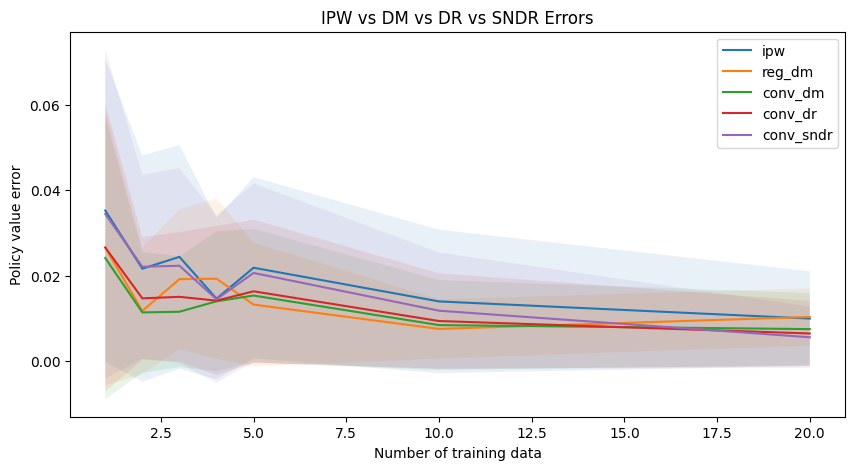

<Figure size 640x480 with 0 Axes>

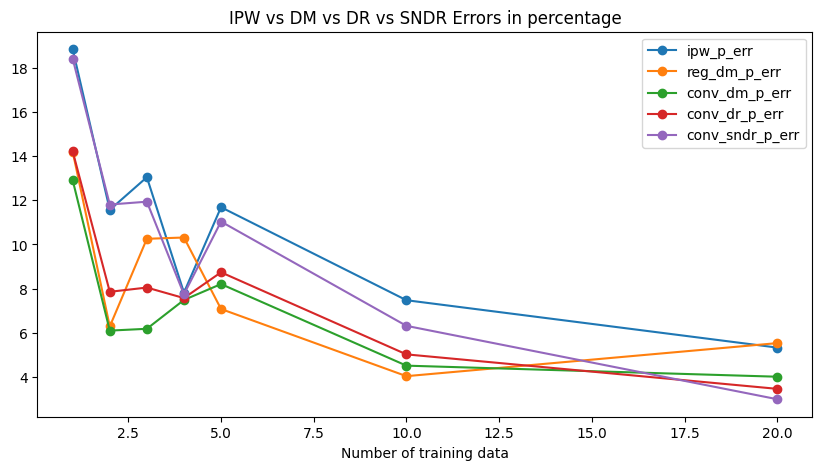

<Figure size 640x480 with 0 Axes>

In [19]:
plot_results(df1)

#### Optimal policy

$$emb = gt

In [20]:
temp_data = dataset.copy()
temp_data['our_a'] = dataset["emb_a"]
temp_data['our_x'] = dataset["emb_x"]

In [21]:
df2 = no_learning_trial(num_runs, num_neighbors, num_rounds_list, temp_data)

In [22]:
df2

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,ipw_p_err,reg_dm_p_err,conv_dm_p_err,conv_dr_p_err,conv_sndr_p_err,ipw_var,reg_dm_var,conv_dm_var,conv_dr_var,conv_sndr_var
1,0.1940,0.0411,0.0296,0.0262,0.0327,0.0451,21.1555,15.2460,13.4769,16.8303,23.2599,0.0548,0.0344,0.0364,0.0440,0.0557
2,0.1940,0.0319,0.0109,0.0169,0.0192,0.0222,16.4564,5.6155,8.7052,9.9057,11.4280,0.0381,0.0130,0.0197,0.0231,0.0284
3,0.1940,0.0221,0.0160,0.0153,0.0184,0.0227,11.3880,8.2663,7.8880,9.4853,11.7087,0.0263,0.0152,0.0175,0.0196,0.0250
4,0.1940,0.0221,0.0186,0.0152,0.0173,0.0203,11.3675,9.5898,7.8230,8.9246,10.4616,0.0292,0.0191,0.0197,0.0222,0.0256
5,0.1940,0.0174,0.0136,0.0154,0.0151,0.0165,8.9556,7.0279,7.9528,7.7855,8.5283,0.0197,0.0153,0.0190,0.0188,0.0200
10,0.1940,0.0138,0.0083,0.0115,0.0114,0.0117,7.1272,4.2695,5.9106,5.8685,6.0450,0.0142,0.0076,0.0122,0.0119,0.0121
20,0.1940,0.0089,0.0111,0.0066,0.0060,0.0063,4.5777,5.6995,3.4119,3.1068,3.2440,0.0098,0.0070,0.0080,0.0075,0.0075


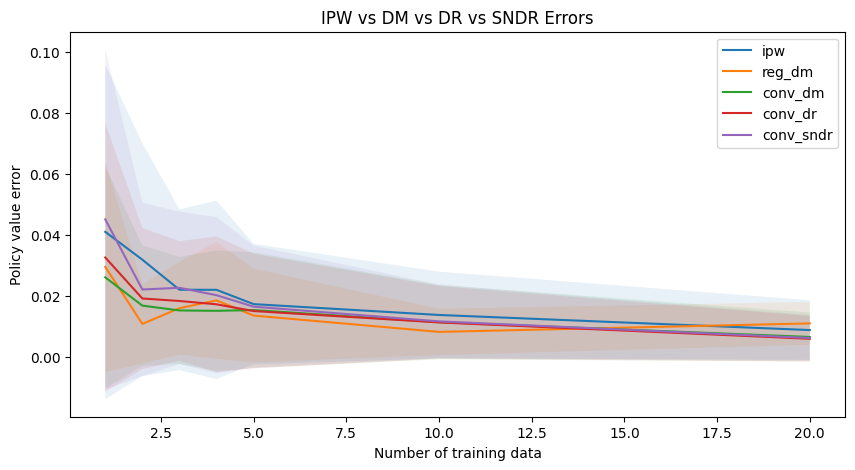

<Figure size 640x480 with 0 Axes>

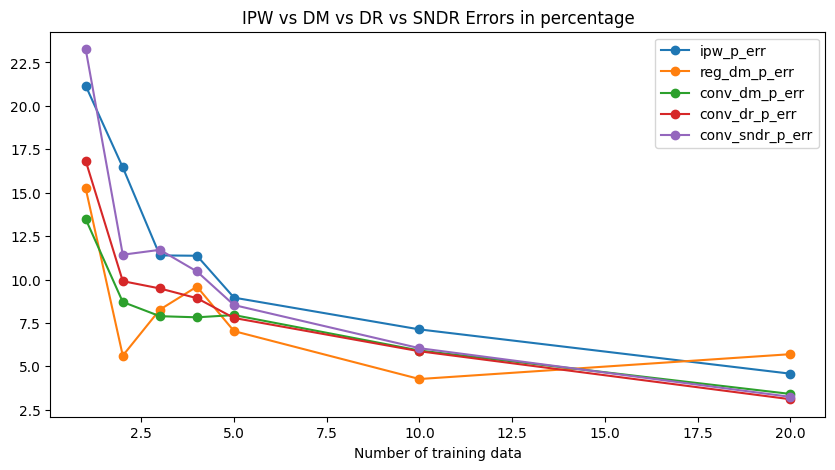

<Figure size 640x480 with 0 Axes>

In [23]:
plot_results(df2)

#### Random Policy

$$emb = noise$$

In [24]:
new_x = random_.normal(size=(dataset_params["n_users"], dataset_params["emb_dim"]))
new_a = random_.normal(size=(dataset_params["n_actions"], dataset_params["emb_dim"]))

temp_data['our_a'] = new_a
temp_data['our_x'] = new_x

In [25]:
df3 = no_learning_trial(num_runs, num_neighbors, num_rounds_list, temp_data)

In [26]:
df3

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,ipw_p_err,reg_dm_p_err,conv_dm_p_err,conv_dr_p_err,conv_sndr_p_err,ipw_var,reg_dm_var,conv_dm_var,conv_dr_var,conv_sndr_var
1,0.1439,0.0299,0.0125,0.0187,0.0236,0.0303,20.7738,8.6553,13.0201,16.3788,21.0771,0.0326,0.0158,0.0184,0.0239,0.0328
2,0.1439,0.0259,0.0125,0.0164,0.0199,0.0246,17.9747,8.6906,11.3923,13.8150,17.1255,0.0174,0.0135,0.0138,0.0132,0.0168
3,0.1439,0.0182,0.0140,0.0178,0.0166,0.0152,12.6399,9.7003,12.3884,11.5595,10.5559,0.0224,0.0153,0.0203,0.0188,0.0173
4,0.1439,0.0158,0.0116,0.0145,0.0151,0.0170,10.9609,8.0834,10.0696,10.5275,11.8271,0.0198,0.0127,0.0156,0.0157,0.0172
5,0.1439,0.0118,0.0114,0.0101,0.0095,0.0095,8.2088,7.9476,7.0455,6.6299,6.6196,0.0132,0.0131,0.0123,0.0116,0.0124
10,0.1439,0.0070,0.0068,0.0059,0.0054,0.0056,4.8519,4.7182,4.1252,3.7262,3.8615,0.0083,0.0076,0.0075,0.0068,0.0068
20,0.1439,0.0047,0.0038,0.0062,0.0054,0.0049,3.2917,2.6324,4.3414,3.7781,3.3896,0.0049,0.0055,0.0064,0.0059,0.0061


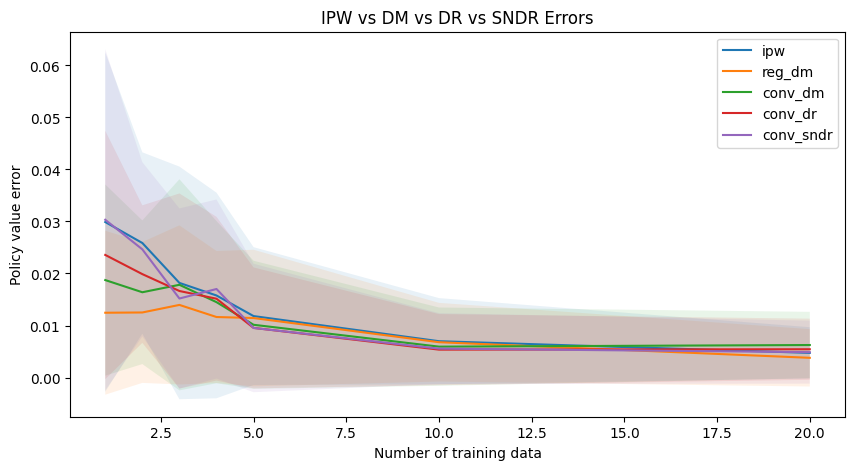

<Figure size 640x480 with 0 Axes>

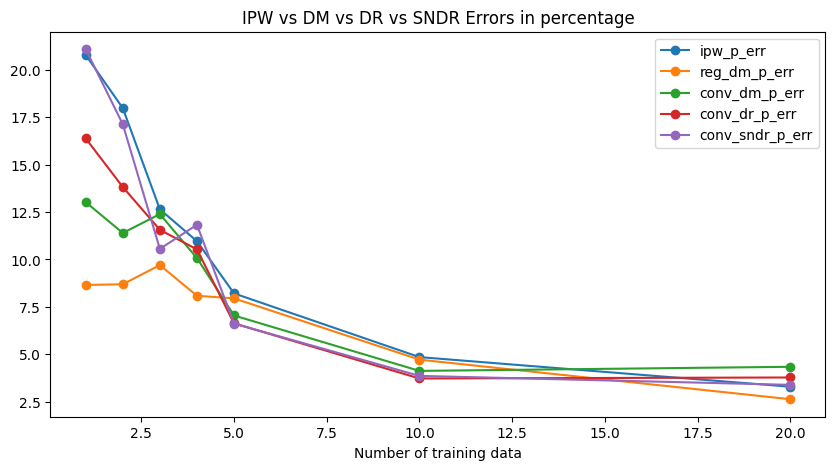

<Figure size 640x480 with 0 Axes>

In [27]:
plot_results(df3)

#### Iterative improvement
At each iteration the model embeddings get closer to the ground truth - $$emb = (1-\epsilon_t) * gt + \epsilon_t * noise$$

In [28]:
df_iterative_improvment = df3.iloc[5:].copy()
df_iterative_improvment['noise level'] = 10

for i in range(1, 11):
    temp_data['our_a'] = ((10-i) * new_a + i * dataset["emb_a"]) /10
    temp_data['our_x'] = ((10-i) * new_x + i * dataset["emb_x"]) /10

    rounds = [num_rounds_list[-1]]
    df = no_learning_trial(num_runs, num_neighbors, rounds, temp_data)
    df['noise level'] = 10 - i
    df_iterative_improvment = pd.concat([df_iterative_improvment, df])

In [29]:
keys_for_display = ['noise level', 'policy_rewards', 
                    'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr',
                    'ipw_var', 'reg_dm_var', 'conv_dm_var', 'conv_dr_var', 'conv_sndr_var']

In [45]:
df_iterative_improvment.iloc[1:][keys_for_display[1:]]

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,ipw_var,reg_dm_var,conv_dm_var,conv_dr_var,conv_sndr_var
noise level,,,,,,,,,,,
10,0.1439,0.0047,0.0038,0.0062,0.0054,0.0049,0.0049,0.0055,0.0064,0.0059,0.0061
9,0.1445,0.0031,0.0035,0.0042,0.0044,0.0056,0.0041,0.0045,0.0047,0.0050,0.0066
8,0.1474,0.0052,0.0036,0.0046,0.0043,0.0047,0.0054,0.0054,0.0047,0.0050,0.0063
7,0.1525,0.0074,0.0042,0.0039,0.0037,0.0050,0.0061,0.0055,0.0043,0.0048,0.0065
6,0.1592,0.0098,0.0056,0.0033,0.0041,0.0068,0.0086,0.0057,0.0059,0.0066,0.0087
5,0.1667,0.0101,0.0064,0.0040,0.0041,0.0045,0.0079,0.0051,0.0058,0.0056,0.0057
4,0.1743,0.0138,0.0077,0.0064,0.0065,0.0069,0.0105,0.0064,0.0071,0.0077,0.0095
3,0.1813,0.0121,0.0098,0.0069,0.0071,0.0086,0.0134,0.0076,0.0093,0.0096,0.0107
2,0.1870,0.0163,0.0099,0.0085,0.0086,0.0094,0.0144,0.0072,0.0105,0.0107,0.0121


In [31]:
df_iterative_improvment.set_index('noise level', inplace=True)

<Axes: title={'center': 'IPW vs DM vs DR vs SNDR Errors'}, xlabel='noise level'>

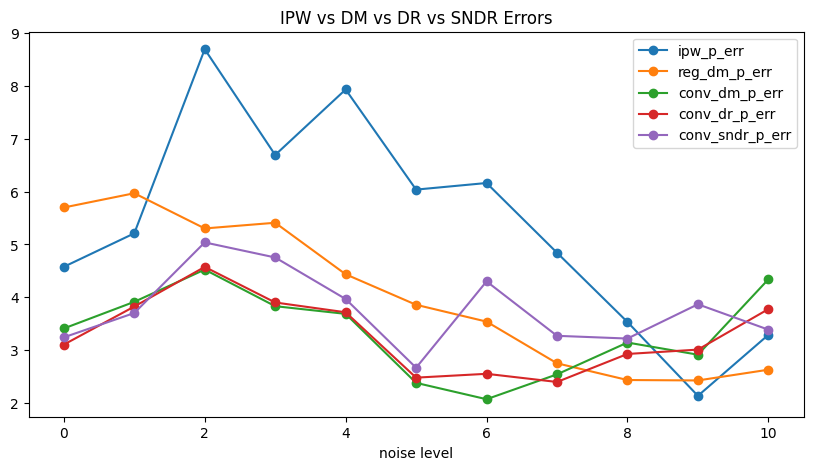

In [42]:
df_iterative_improvment.iloc[1:].plot(
    y=["ipw_p_err",	"reg_dm_p_err",	"conv_dm_p_err", "conv_dr_p_err", "conv_sndr_p_err"],
    title="IPW vs DM vs DR vs SNDR Errors",
    figsize=(10, 5),
    marker="o",
)

## Learning

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [36]:
# num_runs = 3
num_runs = 1

In [66]:
def get_opl_results_dict(reg_results, conv_results):
    reward = conv_results[:, 0]
    return    dict(
                policy_rewards=np.mean(reward),
                ipw=np.mean(abs(conv_results[: ,3] - reward)),
                reg_dm=np.mean(abs(reg_results - reward)),
                conv_dm=np.mean(abs(conv_results[: ,1] - reward)),
                conv_dr=np.mean(abs(conv_results[: ,2] - reward)),
                conv_sndr=np.mean(abs(conv_results[: ,4] - reward)),

                ipw_var=np.var(conv_results[: ,3]),
                reg_dm_var=np.var(reg_results),
                conv_dm_var=np.var(conv_results[: ,1]),
                conv_dr_var=np.var(conv_results[: ,2]),
                conv_sndr_var=np.var(conv_results[: ,4]),

                                
                # ipw_p_err=np.mean(abs(conv_results[: ,3] - reward) / reward) * 100,
                # reg_dm_p_err=np.mean(abs(reg_results - reward) / reward) * 100,
                # conv_dm_p_err=np.mean(abs(conv_results[: ,1] - reward) / reward) * 100,
                # conv_dr_p_err=np.mean(abs(conv_results[: ,2] - reward) / reward) * 100,
                # conv_sndr_p_err=np.mean(abs(conv_results[: ,4] - reward) / reward) * 100,
                
                action_diff_to_real=np.mean(conv_results[: ,5]),
                action_delta=np.mean(conv_results[: ,6]),
                context_diff_to_real=np.mean(conv_results[: ,7]),
                context_delta=np.mean(conv_results[: ,8])
                )

In [67]:
# 4. Define the training function
def train(model, train_loader, neighborhood_model, num_epochs=1, lr=0.0001):

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr) # here we can change the learning rate
    criterion = SNDRPolicyLoss()

    model.train() # Set the model to training mode
    tq = tqdm(range(num_epochs))
    for epoch in tq:
        running_loss = 0.0
        total_samples = 0
        
        for user_idx, action_idx, rewards, original_prob in train_loader:
            # Move data to GPU if available
            if torch.cuda.is_available():
                user_idx = user_idx.to(device) 
                action_idx = action_idx.to(device)
                rewards = rewards.to(device)
                original_prob = original_prob.to(device) 
            
            # Forward pass
            policy = model(user_idx)
            pscore = original_prob[torch.arange(user_idx.shape[0]), action_idx.type(torch.long)]
            
            scores = torch.tensor(neighborhood_model.predict(user_idx.cpu().numpy()))
            
            loss = criterion(
                              pscore,
                              scores,
                              policy, 
                              rewards, 
                              action_idx.type(torch.long), 
                              )
            
            # Zero the gradients Backward pass and optimization
            optimizer.zero_grad()

            loss.backward()       
            optimizer.step()
            
            # update neighborhood
            # action_emb, context_emb = model.get_params()
            
            # Calculate running loss and accuracy
            running_loss += loss.item()
            total_samples += 1

            # Print statistics after each epoch
            epoch_loss = running_loss / total_samples
            tq.set_description(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
            
        # neighborhood_model.update(action_emb.detach().numpy(), context_emb.detach().numpy())


In [ ]:
def trainer_trial(
                  num_runs,
                  num_neighbors,
                  num_rounds_list,
                  dataset,
                  batch_size,
                  num_epochs,
                  lr=0.001
                  ):
    dm = DM()
    results = {}

    our_x, our_a = dataset["our_x"], dataset["our_a"]
    emb_x, emb_a = dataset["emb_x"], dataset["emb_a"]
    
    original_x, original_a = dataset["original_x"], dataset["original_a"]
    n_users, n_actions, emb_dim = dataset["n_users"], dataset["n_actions"], dataset["emb_dim"]

    for train_size in num_rounds_list:
        reg_results, conv_results = [], []
        for run in range(num_runs):

            pi_0 = np.ones_like(dataset["q_x_a"])/(dataset["n_actions"])
            original_policy_prob = np.expand_dims(pi_0, -1)
            simulation_data = create_simluation_data_from_pi(
                                                            pi_0,
                                                            dataset["q_x_a"],
                                                            dataset["n_users"],
                                                            dataset["n_actions"],
                                                            random_state=train_size*(run+1)
                                                            )
            
            # test_data = get_test_data(dataset, simulation_data, n_test_data)
            
            # idx = np.arange(train_size) + n_test_data
            idx = np.arange(train_size)
            train_data = get_train_data(n_actions, train_size, simulation_data, idx, our_x)
            
            regression_model = RegressionModel(
                                                n_actions=n_actions,
                                                action_context=our_x,
                                                base_model=LogisticRegression(random_state=12345)
                                                )
            
            regression_model.fit(train_data['x'], 
                        train_data['a'],
                        train_data['r'],
                        original_policy_prob[train_data['x_idx'],
                        train_data['a']].squeeze()
                        )

            neighberhoodmodel = NeighborhoodModel(
                                                    train_data['x_idx'],
                                                    train_data['a'], 
                                                    our_a,
                                                    our_x, 
                                                    train_data['r'], 
                                                    num_neighbors=num_neighbors
                                                )
            

            model = CFModel(
                            n_users, 
                            n_actions, 
                            emb_dim, 
                            initial_user_embeddings=torch.tensor(our_x), 
                            initial_actions_embeddings=torch.tensor(our_a)
                            )
            
            cf_dataset =  CustomCFDataset(
                                       train_data['x_idx'], 
                                       train_data['a'], 
                                       train_data['r'], 
                                       original_policy_prob[train_data['x_idx']]
                                       )
            
            train_loader = DataLoader(cf_dataset, batch_size=batch_size, shuffle=False)
            
            train(model, train_loader, neighberhoodmodel, num_epochs=num_epochs, lr=lr)

            our_a, our_x = model.get_params()
            our_a, our_x = our_a.detach().cpu().numpy(), our_x.detach().cpu().numpy()

            policy = np.expand_dims(softmax(our_x @ our_a.T, axis=1), -1)

            # reg_dm = dm.estimate_policy_value(policy[test_data['x_idx']], regression_model.predict(test_data['x']))
            reg_dm = dm.estimate_policy_value(policy[train_data['x_idx']], regression_model.predict(train_data['x']))

            reg_results.append(reg_dm)

            # conv_results.append(eval_policy(neighberhoodmodel, test_data, original_policy_prob[test_data['x_idx']], policy))
            conv_results.append(eval_policy(neighberhoodmodel, train_data, original_policy_prob[train_data['x_idx']], policy))

            conv_results[-1] = np.append(calc_reward(dataset, policy), conv_results[-1])
            conv_results[-1] = np.append(conv_results[-1], [np.mean(np.abs(emb_a-our_a)), np.mean(np.abs(original_a-our_a))])

            # temp.append(np.mean(emb_a-our_a, axis=0))
            
            conv_results[-1] = np.append(conv_results[-1], [np.mean(np.abs(emb_x-our_x)), np.mean(np.abs(original_x-our_x))])
            
            our_a, our_x = original_a.copy(), original_x.copy()

        reg_results = np.array(reg_results)
        conv_results = np.array(conv_results)

        results[train_size] = get_opl_results_dict(reg_results, conv_results)
    
    return pd.DataFrame.from_dict(results, orient='index')

In [115]:
dataset_params = dict(
                    n_actions= 150,
                    n_users = 150,
                    emb_dim = 2,
                    # sigma = 0.1,
                    eps = 0.5
                    )

train_dataset = generate_dataset(dataset_params)

In [116]:
temp = []

In [117]:
num_runs = 1

Regular Reinforce grad (iw * log_p * R)

In [118]:
df4 = trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size+100, num_epochs=1, lr=0.05)

Epoch [1/1], Loss: 0.7833: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


In [119]:
df4

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,ipw_var,reg_dm_var,conv_dm_var,conv_dr_var,conv_sndr_var,action_diff_to_real,action_delta,context_diff_to_real,context_delta
1,0.1652,0.0613,0.0029,0.0007,0.0568,0.0493,0.0000,0.0000,0.0000,0.0000,0.0000,0.2703,0.0020,0.3066,0.0027
2,0.1649,0.0178,0.0029,0.0103,0.0192,0.0184,0.0000,0.0000,0.0000,0.0000,0.0000,0.2669,0.0054,0.3029,0.0063
3,0.1646,0.0009,0.0055,0.0088,0.0085,0.0086,0.0000,0.0000,0.0000,0.0000,0.0000,0.2673,0.0051,0.2866,0.0227
4,0.1643,0.0030,0.0039,0.0142,0.0159,0.0158,0.0000,0.0000,0.0000,0.0000,0.0000,0.2636,0.0087,0.2756,0.0336
5,0.1636,0.0149,0.0037,0.0036,0.0147,0.0136,0.0000,0.0000,0.0000,0.0000,0.0000,0.2707,0.0017,0.2872,0.0220
10,0.1625,0.0092,0.0004,0.0098,0.0070,0.0072,0.0000,0.0000,0.0000,0.0000,0.0000,0.2647,0.0076,0.2474,0.0618
20,0.1605,0.0067,0.0092,0.0085,0.0056,0.0057,0.0000,0.0000,0.0000,0.0000,0.0000,0.2714,0.0009,0.1990,0.1103


In [109]:
local = np.array(temp)

In [113]:
local

array([[-0.33067225, -0.64289707],
       [-0.32101971, -0.63986197],
       [-0.31365674, -0.63036833],
       [-0.31557426, -0.63215401],
       [-0.31238063, -0.62927482],
       [-0.29708604, -0.60014834],
       [-0.27115068, -0.61059262]])

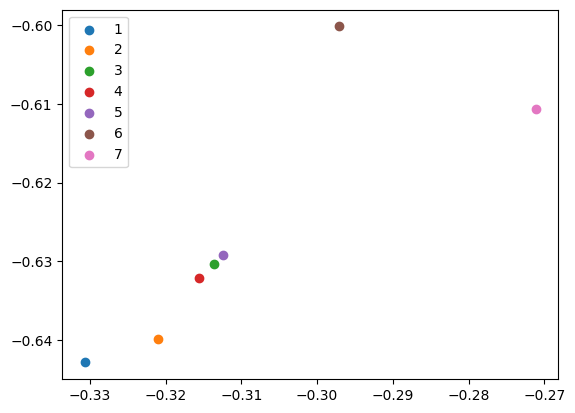

In [111]:

for p in range(local.shape[0]):
    plt.scatter(local[p, 0], local[p, 1], label=f"{p+1}")
plt.legend()
plt.show()

In [77]:
df4

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,ipw_var,reg_dm_var,conv_dm_var,conv_dr_var,conv_sndr_var,action_diff_to_real,action_delta,context_diff_to_real,context_delta
1,0.1682,0.0193,0.0198,0.0160,0.0176,0.0170,0.0005,0.0002,0.0002,0.0004,0.0004,0.8501,0.0050,0.5199,0.0050
2,0.1681,0.0239,0.0147,0.0195,0.0267,0.0262,0.0001,0.0003,0.0000,0.0000,0.0000,0.8505,0.0074,0.5201,0.0072
3,0.1680,0.0156,0.0140,0.0089,0.0199,0.0195,0.0002,0.0001,0.0001,0.0004,0.0004,0.8509,0.0091,0.5201,0.0088
4,0.1679,0.0134,0.0214,0.0057,0.0175,0.0169,0.0002,0.0000,0.0000,0.0002,0.0002,0.8514,0.0110,0.5204,0.0106
5,0.1679,0.0168,0.0217,0.0118,0.0165,0.0164,0.0002,0.0001,0.0002,0.0003,0.0003,0.8515,0.0129,0.5200,0.0120
10,0.1674,0.0088,0.0162,0.0100,0.0063,0.0064,0.0001,0.0001,0.0001,0.0000,0.0000,0.8537,0.0197,0.5213,0.0183
20,0.1667,0.0106,0.0221,0.0101,0.0093,0.0093,0.0002,0.0000,0.0001,0.0001,0.0001,0.8582,0.0319,0.5229,0.0295


Less epochs, different lr

In [ ]:
df5 = trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, num_epochs=5, lr=0.001)

Epoch [5/5], Loss: 0.8293: 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


In [52]:
df5

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
1,0.1871,0.0054,0.0613,0.0200,0.0251,0.0258,0.1831,0.0088,0.3024,0.0011
2,0.1870,0.0856,0.0263,0.0074,0.0717,0.0751,0.1872,0.0127,0.3024,0.0034
3,0.1870,0.0527,0.0420,0.0016,0.0644,0.0716,0.1902,0.0184,0.3023,0.0058
4,0.1868,0.0186,0.0448,0.0353,0.0188,0.0173,0.1929,0.0216,0.3027,0.0074
5,0.1868,0.0381,0.0319,0.0102,0.0162,0.0134,0.1931,0.0249,0.3031,0.0104
10,0.1866,0.0688,0.0350,0.0025,0.0612,0.0590,0.2023,0.0347,0.3023,0.0195
20,0.1861,0.0310,0.0413,0.0031,0.0295,0.0301,0.2105,0.0506,0.3064,0.0347


In [ ]:
df6 = trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, num_epochs=10, lr=0.003)

Epoch [10/10], Loss: 1.4731: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


In [54]:
df6

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
1,0.1866,0.0452,0.0604,0.0177,0.0008,0.0006,0.2028,0.0545,0.3022,0.0066
2,0.1857,0.1855,0.0247,0.0090,0.1825,0.1645,0.2321,0.0815,0.3026,0.0214
3,0.1857,0.1944,0.0400,0.0058,0.2190,0.1942,0.2589,0.1177,0.3043,0.0372
4,0.1844,0.1238,0.0421,0.0240,0.1136,0.1044,0.2794,0.1414,0.3089,0.0482
5,0.1852,0.2002,0.0297,0.0024,0.2254,0.1598,0.2845,0.1603,0.3103,0.0696
10,0.1843,0.2888,0.0317,0.0229,0.3566,0.2512,0.3445,0.2170,0.3150,0.1307
20,0.1825,0.2664,0.0370,0.0330,0.3291,0.2356,0.3939,0.2952,0.3591,0.2215


In [83]:
df7 = trainer_trial(num_runs, num_neighbors, num_rounds_list[:-3], train_dataset, batch_size+100, num_epochs=10, lr=0.05)

Epoch [10/10], Loss: -5.3861: 100%|██████████| 10/10 [00:00<00:00, 26.39it/s]


In [84]:
df7

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,ipw_var,reg_dm_var,conv_dm_var,conv_dr_var,conv_sndr_var,action_diff_to_real,action_delta,context_diff_to_real,context_delta
1,0.1754,0.0161,0.0271,0.0191,0.0206,0.0369,0.0004,0.0002,0.0003,0.0004,0.0016,0.8757,0.4744,0.6341,0.4466
2,0.1814,0.0790,0.0195,0.0141,0.0118,0.0670,0.0061,0.0003,0.0000,0.0000,0.0011,0.9461,0.7547,0.8317,0.7232
3,0.1815,0.3586,0.0218,0.0153,0.0368,0.2337,0.1785,0.0002,0.0002,0.0021,0.0779,1.0297,1.0165,1.1834,1.0791
4,0.1810,0.1778,0.0343,0.0067,0.0243,0.1527,0.0000,0.0000,0.0001,0.0004,0.0128,1.1645,1.2830,1.6506,1.5502


In [ ]:
df['getting closer to real emb'] = df['diff_to_real'].max() - df['diff_to_real']

KeyError: 'diff_to_real'

<Axes: >

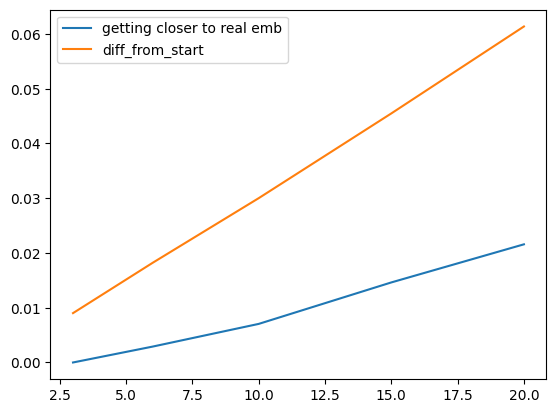

In [ ]:
df.plot(y=['getting closer to real emb', 'diff_from_start'])